# iminuit 2.32.0 released with support for user-defined Hessian

In [iminuit's v2.32.0 release](https://github.com/scikit-hep/iminuit/releases/tag/v2.32.0) I updated the C++ Minuit2 in ROOT for the first time since 2022. We don't sync ROOT often, because the C++ Code changes very infrequently. But actually already later in 2022 a feature was added, that is quite useful to expose in iminuit as well, the ability for users to provide user-defined second derivatives of the cost function, in form of the Hessian matrix and the so-called G2 function, which is the diagonal of the Hessian.

In this release, that new functionality in the C++ code was included and exposed to Python. You can now provide a gradient and a G2 function, and thus side-step numerical differentiation during the minimization. If you provide a Hessian matrix as well, you can also compute the HESSE uncertainties without numerical differentiation.

Why would you want to do that? To speed up minimization and to increase accuracy, especially when your fit has a large number of parameters.

iminuit's minimization algorithm MIGRAD uses a mix of gradient descent with line search and a [quasi-Newton method](https://en.wikipedia.org/wiki/Quasi-Newton_method) to find the minimum. Both require a first derivative, which MIGRAD usually computes numerically from finite differences. This requires many function evaluations and the gradient may not be accurate. As an alternative, iminuit also allows the user to compute the gradient and pass it to MIGRAD. The Hessian is not computed numerically, instead it is estimated from the successive gradients using the [Davidon-Fletcher-Powell formula](https://en.wikipedia.org/wiki/Davidon%E2%80%93Fletcher%E2%80%93Powell_formula). However, depending on the strategy used and some diagnostics that MIGRAD collects, MIGRAD may occasionally compute the Hessian matrix numerically every few steps. The G2 function is used during line search, and to get an initial approximation of the Hessian.

If you have a way to compute the G2 function or the Hessian matrix analytically or with automatic differentiation, it is usually faster to do that than to rely on numerical differentiation. You also avoid issues that arise when these derivatives are computed near pathological points, for example $\ln(x)$ at $x \rightarrow 0$, which occurs, for example, when the [Cash statistic](https://doi.org/10.1086/156922) is used.

Computing derivatives analytically is often possible, but it is usually too much hassle to do manually. Automatic differentiation (AD) is an interesting alternative, because it allows one to compute exact derivatives efficiently when the cost function is already written as a vectorized Numpy functions. We demonstrate automatic differentiation with the JAX module, which can not only compute derivatives, but also accelerates the computation of Python code (including the gradient code) with a just-in-time compiler. This blog entry is based on the [AD study in the iminuit documentation](https://scikit-hep.org/iminuit/notebooks/automatic_differentiation.html).

[Recommended read: Gentle introduction to AD](https://www.kaggle.com/borisettinger/gentle-introduction-to-automatic-differentiation)

## Fit of a gaussian model to a histogram

We fit a gaussian to a histogram using a maximum-likelihood approach based on Poisson statistics. This example is used to investigate how automatic differentiation can accelerate a typical fit in a counting experiment.

To compare fits with and without passing an analytic gradient fairly, we use `Minuit.strategy = 0`, which prevents Minuit from automatically computing the Hesse matrix after the fit.

In [21]:
from timeit import repeat

import jax
import numpy as np  # original numpy still needed, since jax does not cover full API
from jax import numpy as jnp  # replacement for normal numpy
from jax.scipy.stats import norm
from matplotlib import pyplot as plt

import iminuit
from iminuit import Minuit

jax.config.update(
    "jax_enable_x64", True
)  # enable float64 precision, default is float32

print(f"JAX version {jax.__version__}")
print(f"iminuit version {iminuit.__version__}")

JAX version 0.8.0
iminuit version 2.32.0


We generate some toy data and write the negative log-likelihood (nll) for a fit to binned data, assuming Poisson-distributed counts.

In [22]:
# generate some toy data
rng = np.random.default_rng(seed=1)
n, xe = np.histogram(rng.normal(size=10000), bins=1000)

In [23]:
def safe_log(x):
    # to avoid log of zero, we add a tiny constant
    return jnp.log(x + 1e-100)


def cash_statistic(n, nexp):
    return jnp.sum(nexp - n + n * (safe_log(n) - safe_log(nexp)))


def nll(par):  # negative log-likelihood with constants stripped
    amp, mu, sigma = par
    p = norm.cdf(xe, mu, sigma)
    # nexp is the expected number of counts per bin
    nexp = amp * jnp.diff(p)
    return cash_statistic(n, nexp)

We use a helper function to call Minuit with or without the gradient, g2 function, or hessian function.

In [24]:
start_values = (1.5 * np.sum(n), 1.0, 2.0)
limits = ((0, None), (None, None), (0, None))


def make_and_run_minuit(fcn, grad=None, g2=None, hessian=None):
    m = Minuit(fcn, start_values,
               grad=grad, g2=g2, hessian=hessian,
               name=("amp", "mu", "sigma"))
    m.errordef = Minuit.LIKELIHOOD
    m.limits = limits
    return m.migrad()

Let's warm up the JIT for each variant and confirm that the result of the minimization is always the same.

In [25]:
m1 = make_and_run_minuit(nll)
m1.fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 496.2                      │              Nfcn = 82               │
│ EDM = 1.86e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

In [26]:
m2 = make_and_run_minuit(jax.jit(nll), grad=jax.jit(jax.grad(nll)))
m2.fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 496.2                      │         Nfcn = 50, Ngrad = 6         │
│ EDM = 1.84e-08 (Goal: 0.0001)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

In [27]:
def g2(par):
    # this computation of g2 is wasteful
    m = jax.hessian(nll)(par)
    return jnp.diag(m)

m3 = make_and_run_minuit(jax.jit(nll), grad=jax.jit(jax.grad(nll)), g2=jax.jit(g2))
m3.fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 496.2                      │    Nfcn = 42, Ngrad = 7, Ng2 = 7     │
│ EDM = 3.8e-06 (Goal: 0.0001)     │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

In [28]:
m4 = make_and_run_minuit(jax.jit(nll), grad=jax.jit(jax.grad(nll)), hessian=jax.jit(jax.hessian(nll)))
m4.fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 496.2                      │  Nfcn = 18, Ngrad = 7, Nhessian = 2  │
│ EDM = 3.81e-06 (Goal: 0.0001)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

As expected, we always get the same result. We use a wasteful implementation of computing the g2 function here, because we first compute the full hessian and then extract its diagonal. This is the simpled way to implement this, but obviously not good if you want to get maximum performance. However, I tried other implementations and those are not faster.

Since we care about performance, let's measure the times. Note that the timings shown here only for a warm-up JIT. For a cold JIT, the compilation time needs to be added, which is significant, but a one-time payment.

In [29]:
times:dict[str, str|np.floating] = {
    "no grad": "m1",
    "grad": "m2",
    "grad, g2": "m3",
    "grad, hessian": "m4",
}
for k, v in times.items():
    t = repeat(
        f"{v}.values = start_values; {v}.migrad()",
        f"from __main__ import {v}, start_values",
        number=10, repeat=5
    )
    times[k] = np.mean(t)

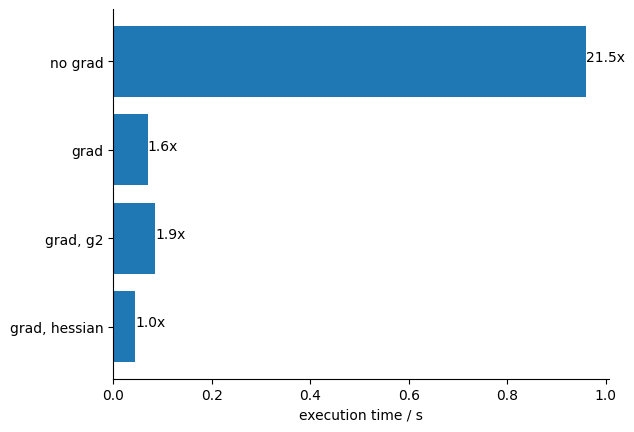

In [30]:
x = np.fromiter((x for x in times.values()), dtype=float)
xmin = np.min(x)

y = -np.arange(len(times)).astype(float)
plt.barh(y, x)
for yi, k, v in zip(y, times, x):
    plt.text(v, yi, f"{v / xmin:.1f}x")
plt.yticks(y, list(times.keys()))
for loc in ("top", "right"):
    plt.gca().spines[loc].set_visible(False)
plt.xlabel("execution time / s");

Conclusions:

- We obtain a big performance boost from using the JAX-computed gradient.
- There is a minor boost when we also provide the JAX-computed hessian matrix. This makes sense, because the Hessian is computed only two times, once at the start and once at the end, when convergence is reached.
- Using the g2 function in this case is slowing down the computation, because we cannot compute it as efficiently with JAX.

In general, the gain from using a JAX-computed gradient will become even larger when the cost function has more parameters.